Base case - Time: 12.333s, Energy: 131.463J
N satellites: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Phi values: 1600 points from 0.00 to 1.60
ISL/GL ratio: 1000 points from 0.40 to 100.00
Computing cost grid for all combinations...

Processing n=1 satellites...
  Progress: 1/1000 ISL ratios completed
  Progress: 16/1000 ISL ratios completed
  Progress: 31/1000 ISL ratios completed
  Progress: 46/1000 ISL ratios completed
  Progress: 61/1000 ISL ratios completed
  Progress: 76/1000 ISL ratios completed
  Progress: 91/1000 ISL ratios completed
  Progress: 106/1000 ISL ratios completed
  Progress: 121/1000 ISL ratios completed
  Progress: 136/1000 ISL ratios completed
  Progress: 151/1000 ISL ratios completed
  Progress: 166/1000 ISL ratios completed
  Progress: 181/1000 ISL ratios completed
  Progress: 196/1000 ISL ratios completed
  Progress: 211/1000 ISL ratios completed
  Progress: 226/1000 ISL ratios completed
  Progress: 241/1000 ISL ratios completed
  Progress: 256/1000 ISL ratios completed
  Pr

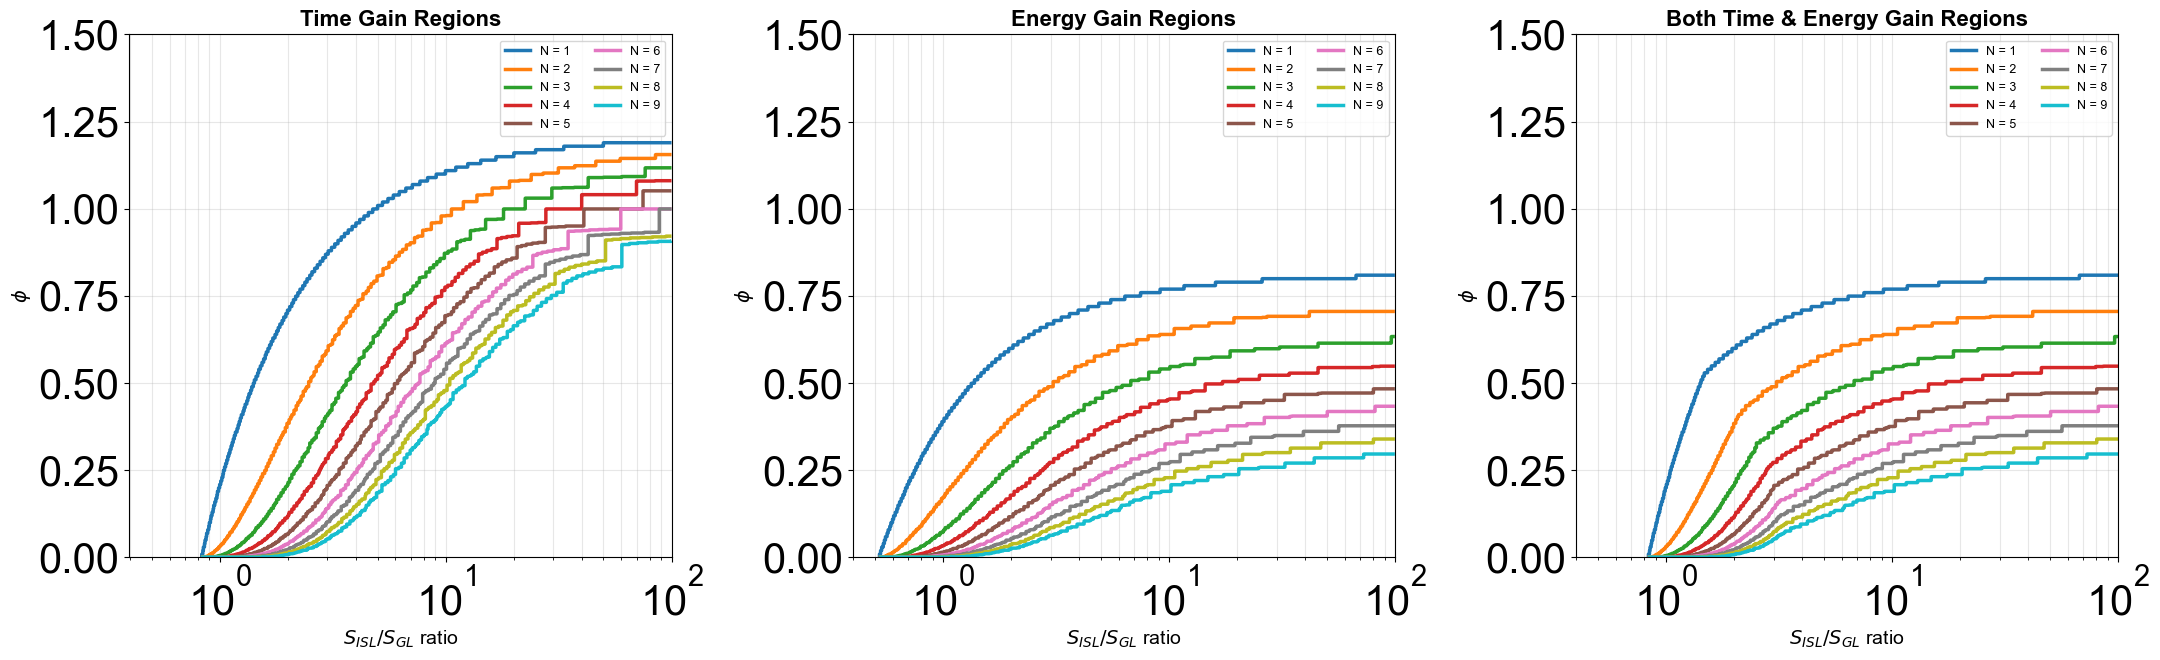


=== Summary Statistics ===

N = 1 satellites:
  Time gain region: 51.8% of parameter space
  Energy gain region: 39.1% of parameter space
  Both gains region: 37.4% of parameter space

N = 2 satellites:
  Time gain region: 43.5% of parameter space
  Energy gain region: 30.7% of parameter space
  Both gains region: 29.4% of parameter space

N = 3 satellites:
  Time gain region: 38.0% of parameter space
  Energy gain region: 24.8% of parameter space
  Both gains region: 23.9% of parameter space

N = 4 satellites:
  Time gain region: 34.0% of parameter space
  Energy gain region: 20.5% of parameter space
  Both gains region: 19.8% of parameter space

N = 5 satellites:
  Time gain region: 30.8% of parameter space
  Energy gain region: 17.0% of parameter space
  Both gains region: 16.5% of parameter space

N = 6 satellites:
  Time gain region: 28.1% of parameter space
  Energy gain region: 14.3% of parameter space
  Both gains region: 14.0% of parameter space

N = 7 satellites:
  Time gain

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Complete Offloading
# - No computing on User Satellite in Offloading case
# - Variation of phi_ec
# - Ratio S_isl / S_gl

with_legend = True
plot_precision = 1000

data_size = 100

config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": {  # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None,  # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None,  # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None,  # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case
# - Computing on User Satellite (OBDH)
# - Ground Link

base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

# Define parameter ranges
n_satellites = range(1, 10, 1)
phi_values = np.arange(0.0, 1.6, 0.001)  # Increased resolution to 0.001 steps
phi_max = 1.5

# s_isl variation: [10^-1 to 10^2] * s_base_ground_link
isl_ratio_values = np.logspace(-0.4, 2, 1000)  # Increased resolution

print(f"N satellites: {list(n_satellites)}")
print(f"Phi values: {len(phi_values)} points from {phi_values[0]:.2f} to {phi_values[-1]:.2f}")
print(f"ISL/GL ratio: {len(isl_ratio_values)} points from {isl_ratio_values[0]:.2f} to {isl_ratio_values[-1]:.2f}")

# Offloading Case - Grid Computation
# - No computing on User Satellite
# - ISL to Edge Node
# - Computing on Edge Node
# - Edge Node ground link

# Offloading configuration
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid for all combinations...")

# Store results: results[n_sat][isl_ratio][phi] = (time_cost, energy_cost)
results = {}

for i, n in enumerate(n_satellites):
    results[n] = {}
    print(f"\nProcessing n={n} satellites...")

    for ratio_idx, isl_ratio in enumerate(isl_ratio_values):
        results[n][isl_ratio] = {}
        s_isl = base_ground_link_speed * isl_ratio

        # ISL transmission setup
        isl = TransmissionNode(speed=float(s_isl))
        after_isl_iteration_time_cost = isl.time_cost(data_size)
        after_isl_iteration_energy_cost = isl.energy_cost(
            data_size,
            energy=off_isl_energy,
            distance=off_isl_distance
        )

        for phi_en_original in phi_values:
            # KEY FIX: Keep original value for dictionary key
            phi_en_computed = (phi_en_original ** (1/n))

            # Process data through ISL
            d_out_isl = isl.process(data_size)

            # Initialize costs with ISL transmission
            iteration_time_cost = after_isl_iteration_time_cost
            iteration_energy_cost = after_isl_iteration_energy_cost

            # First edge computer processing
            edge_computer = ComputingNode(
                speed=off_edge_computer_speed,
                phi=phi_en_computed
            )

            iteration_time_cost += edge_computer.time_cost(d_out_isl)
            iteration_energy_cost += edge_computer.energy_cost(
                d_out_isl,
                energy_uptime=off_edge_computer_energy_uptime,
                energy_io=off_edge_computer_energy_io
            )

            d_out_ec = edge_computer.process(d_out_isl)

            # Additional satellites processing (n-1 more hops)
            if n > 1:
                for _ in range(n - 1):
                    # ISL transmission to next satellite
                    en_isl = TransmissionNode(speed=float(s_isl))
                    iteration_time_cost += en_isl.time_cost(d_out_ec)
                    iteration_energy_cost += en_isl.energy_cost(
                        d_out_ec,
                        energy=off_isl_energy,
                        distance=off_isl_distance
                    )

                    d_out_ec = en_isl.process(d_out_ec)

                    edge_computer = ComputingNode(
                        speed=off_edge_computer_speed,
                        phi=phi_en_computed
                    )

                    iteration_time_cost += edge_computer.time_cost(d_out_ec)
                    iteration_energy_cost += edge_computer.energy_cost(
                        d_out_ec,
                        energy_uptime=off_edge_computer_energy_uptime,
                        energy_io=off_edge_computer_energy_io
                    )

                    d_out_ec = edge_computer.process(d_out_ec)

            # Ground link transmission (fixed speed)
            ground_link = TransmissionNode(speed=float(base_ground_link_speed))
            iteration_time_cost += ground_link.time_cost(d_out_ec)
            iteration_energy_cost += ground_link.energy_cost(
                d_out_ec,
                energy=off_ground_link_energy,
                distance=off_ground_link_distance
            )

            # Store results using ORIGINAL phi value as key
            results[n][isl_ratio][phi_en_original] = (iteration_time_cost, iteration_energy_cost)

        if ratio_idx % 15 == 0:
            print(f"  Progress: {ratio_idx + 1}/{len(isl_ratio_values)} ISL ratios completed")

print("\nGrid computation complete!")

# Create gain regions for visualization
# For each n_satellites, create 2D arrays indicating gain regions

print("Creating gain region maps...")

gain_maps = {}

for n in n_satellites:
    # Create 2D arrays: rows = phi values, columns = isl_ratio values
    time_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    energy_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))
    both_gain_map = np.zeros((len(phi_values), len(isl_ratio_values)))

    for i, phi_en in enumerate(phi_values):
        for j, isl_ratio in enumerate(isl_ratio_values):
            time_cost, energy_cost = results[n][isl_ratio][phi_en]

            # Mark gains
            if time_cost < base_time_cost:
                time_gain_map[i, j] = 1

            if energy_cost < base_energy_cost:
                energy_gain_map[i, j] = 1

            if time_cost < base_time_cost and energy_cost < base_energy_cost:
                both_gain_map[i, j] = 1

    gain_maps[n] = {
        'time': time_gain_map,
        'energy': energy_gain_map,
        'both': both_gain_map
    }

print("Gain region maps created!")

# Plot combined gain regions with outlines only
# Three plots: Time Gain, Energy Gain, Both Gains
# Each plot shows outlines for all n_satellites values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Create meshgrid for contour plots
X, Y = np.meshgrid(isl_ratio_values, phi_values)

# Define colors for different n_satellites
colors = plt.cm.tab10(np.linspace(0, 1, len(n_satellites)))

# Plot 1: Time Gain - All N satellites
for idx, n in enumerate(n_satellites):
    time_map = gain_maps[n]['time']
    # Only plot the contour outline at level 0.5
    contour = ax1.contour(X, Y, time_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax1.set_xscale('log')
ax1.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax1.set_ylabel(r'$\phi$', fontsize=14)
ax1.set_title('Time Gain Regions', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.set_ylim([0, phi_max])

# Create legend
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites)]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 2: Energy Gain - All N satellites
for idx, n in enumerate(n_satellites):
    energy_map = gain_maps[n]['energy']
    # Only plot the contour outline at level 0.5
    contour = ax2.contour(X, Y, energy_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax2.set_xscale('log')
ax2.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax2.set_ylabel(r'$\phi$', fontsize=14)
ax2.set_title('Energy Gain Regions', fontsize=16, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites)]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

# Plot 3: Both Gains - All N satellites
for idx, n in enumerate(n_satellites):
    both_map = gain_maps[n]['both']
    # Only plot the contour outline at level 0.5
    contour = ax3.contour(X, Y, both_map, levels=[0.5],
                          colors=[colors[idx]], linewidths=2.5,
                          linestyles='solid')

ax3.set_xscale('log')
ax3.set_xlabel(r'$S_{ISL} / S_{GL}$ ratio', fontsize=14)
ax3.set_ylabel(r'$\phi$', fontsize=14)
ax3.set_title('Both Time & Energy Gain Regions', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')
ax3.set_ylim([0, phi_max])

# Create legend
legend_elements = [Line2D([0], [0], color=colors[idx], linewidth=2.5, label=f'N = {n}')
                   for idx, n in enumerate(n_satellites)]
ax3.legend(handles=legend_elements, loc='upper right', fontsize=9, ncol=2)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for n in n_satellites:
    time_map = gain_maps[n]['time']
    energy_map = gain_maps[n]['energy']
    both_map = gain_maps[n]['both']

    time_gain_pct = 100 * np.sum(time_map) / time_map.size
    energy_gain_pct = 100 * np.sum(energy_map) / energy_map.size
    both_gain_pct = 100 * np.sum(both_map) / both_map.size

    print(f"\nN = {n} satellites:")
    print(f"  Time gain region: {time_gain_pct:.1f}% of parameter space")
    print(f"  Energy gain region: {energy_gain_pct:.1f}% of parameter space")
    print(f"  Both gains region: {both_gain_pct:.1f}% of parameter space")